In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model, load_model
from skimage import io, transform, color
import matplotlib.pyplot as plt

class DataPreprocessor:
    def __init__(self, base_path):
        self.base_path = base_path
        self.image_size = (256, 256)
    
    def load_images(self, dataset_type='train'):
        image_dir = os.path.join(self.base_path, 'images', dataset_type)
        
        images = []
        masks = []
        
        for filename in os.listdir(image_dir):
            if filename.endswith(('.jpg', '.png', '.jpeg')):
                image_path = os.path.join(image_dir, filename)
                image = io.imread(image_path)
                
                if image.ndim == 3 and image.shape[2] > 3:
                    image = image[:, :, :3]
                
                image = transform.resize(image, self.image_size)
                
                if image.max() > 1:
                    image = image / 255.0
                
                images.append(image)
                
                mask = np.zeros(self.image_size, dtype=np.float32)
                masks.append(mask)
        
        return np.array(images), np.array(masks)

In [7]:
class EdgeDetectionModel:
    def __init__(self, input_shape=(256, 256, 3)):
        self.input_shape = input_shape
    
    def unet_model(self):
        inputs = Input(self.input_shape)
        
        conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
        conv1 = BatchNormalization()(conv1)
        conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
        conv1 = BatchNormalization()(conv1)
        pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
        
        conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
        conv2 = BatchNormalization()(conv2)
        conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
        conv2 = BatchNormalization()(conv2)
        pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
        
        conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
        conv3 = BatchNormalization()(conv3)
        conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
        conv3 = BatchNormalization()(conv3)
        pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
        
        conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
        conv4 = BatchNormalization()(conv4)
        conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
        conv4 = BatchNormalization()(conv4)
        
        up5 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv4)
        up5 = concatenate([up5, conv3], axis=-1)
        conv5 = Conv2D(256, 3, activation='relu', padding='same')(up5)
        conv5 = BatchNormalization()(conv5)
        conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
        conv5 = BatchNormalization()(conv5)
        
        up6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv5)
        up6 = concatenate([up6, conv2], axis=-1)
        conv6 = Conv2D(128, 3, activation='relu', padding='same')(up6)
        conv6 = BatchNormalization()(conv6)
        conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
        conv6 = BatchNormalization()(conv6)
        
        up7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6)
        up7 = concatenate([up7, conv1], axis=-1)
        conv7 = Conv2D(64, 3, activation='relu', padding='same')(up7)
        conv7 = BatchNormalization()(conv7)
        conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
        conv7 = BatchNormalization()(conv7)
        
        outputs = Conv2D(1, 1, activation='sigmoid')(conv7)
        
        model = Model(inputs=inputs, outputs=outputs)
        return model


In [8]:
class ModelTrainer:
    def __init__(self, base_path, output_path):
        self.base_path = base_path
        self.output_path = output_path
        self.preprocessor = DataPreprocessor(base_path)
        self.model_builder = EdgeDetectionModel()
    
    def train(self, epochs=10, batch_size=8):
        X_train, y_train = self.preprocessor.load_images('train')
        
        model = self.model_builder.unet_model()
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
        model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
        
        os.makedirs(self.output_path, exist_ok=True)
        model_path = os.path.join(self.output_path, 'edge_detection_model.keras')
        model.save(model_path)
        return model

class EdgeDetectionInference:
    def __init__(self, model_path):
        self.model = load_model(model_path)
        self.image_size = (256, 256)
    
    def predict_edges(self, image_path):
        image = io.imread(image_path)
        
        if image.ndim == 3 and image.shape[2] > 3:
            image = image[:, :, :3]
        
        image = transform.resize(image, self.image_size)
        
        if image.max() > 1:
            image = image / 255.0
        
        image = np.expand_dims(image, axis=0)
        
        prediction = self.model.predict(image)
        
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(transform.resize(io.imread(image_path), self.image_size))
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.title('Predicted Edges')
        plt.imshow(prediction[0, :, :, 0], cmap='gray')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
        
        return prediction[0, :, :, 0]

Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 415ms/step - accuracy: 0.5631 - loss: 0.7446 - val_accuracy: 0.8945 - val_loss: 0.5193
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 364ms/step - accuracy: 0.9356 - loss: 0.5945 - val_accuracy: 0.9765 - val_loss: 0.4988
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 369ms/step - accuracy: 0.9986 - loss: 0.5103 - val_accuracy: 1.0000 - val_loss: 0.4408
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 373ms/step - accuracy: 1.0000 - loss: 0.4179 - val_accuracy: 1.0000 - val_loss: 0.3447
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 376ms/step - accuracy: 1.0000 - loss: 0.3237 - val_accuracy: 1.0000 - val_loss: 0.2658
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


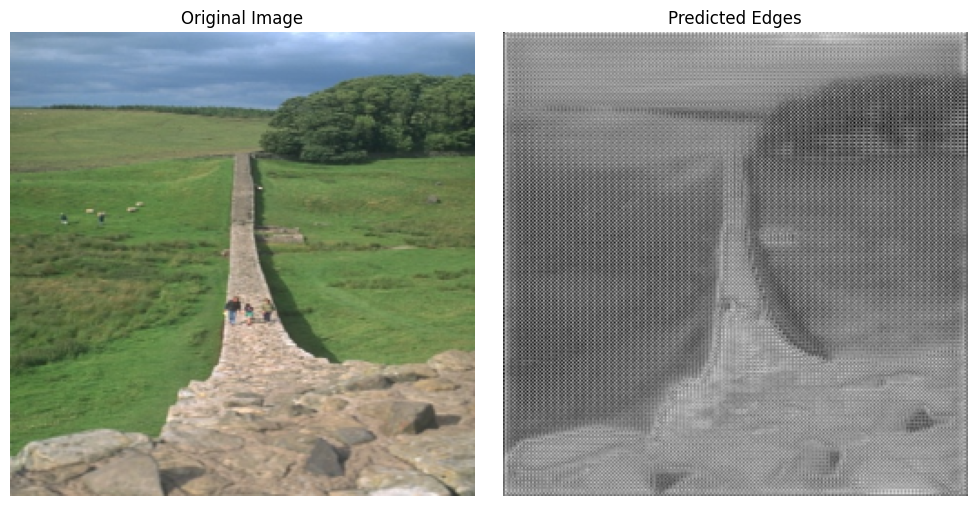

In [9]:
if __name__ == "__main__":
    DATASET_PATH = "/kaggle/input/berkeley-segmentation-dataset-500-bsds500"
    OUTPUT_PATH = "/kaggle/working"
    
    trainer = ModelTrainer(DATASET_PATH, OUTPUT_PATH)
    model = trainer.train(epochs=5)
    
    model_save_path = os.path.join(OUTPUT_PATH, 'edge_detection_model.keras')
    inferencer = EdgeDetectionInference(model_save_path)
    
    sample_image_path = os.path.join(DATASET_PATH, 'images', 'train', 
                                     os.listdir(os.path.join(DATASET_PATH, 'images', 'train'))[0])
    inferencer.predict_edges(sample_image_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


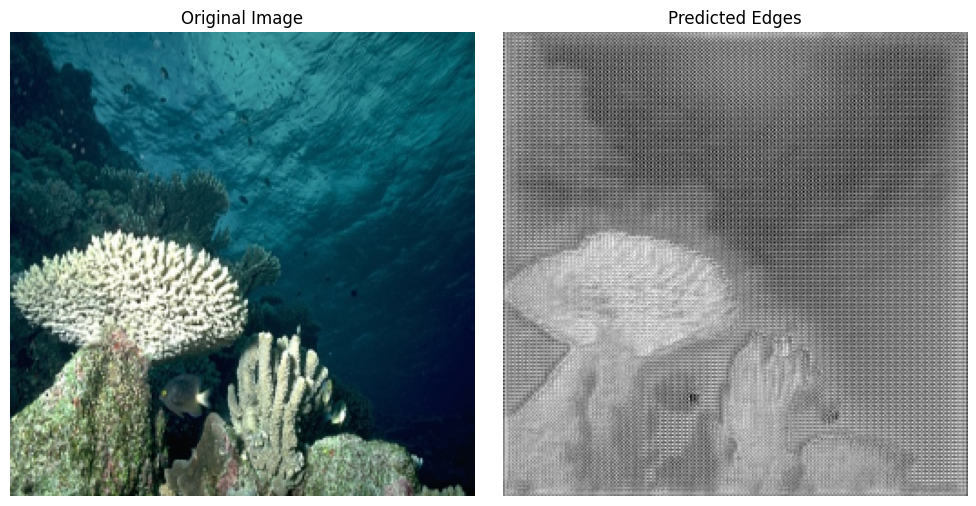

array([[0.21355449, 0.2518197 , 0.23212634, ..., 0.23557   , 0.23371604,
        0.22124097],
       [0.22296925, 0.2381902 , 0.2190205 , ..., 0.23067535, 0.23074706,
        0.2250534 ],
       [0.21377428, 0.24179111, 0.23808111, ..., 0.2158341 , 0.23575224,
        0.21929985],
       ...,
       [0.22747935, 0.23993382, 0.2404436 , ..., 0.23176257, 0.24327351,
        0.22082973],
       [0.22394736, 0.25093096, 0.23334584, ..., 0.2449806 , 0.24501772,
        0.21635771],
       [0.22727405, 0.23890704, 0.23805135, ..., 0.23122734, 0.22178203,
        0.21253546]], dtype=float32)

In [10]:
    inferencer = EdgeDetectionInference(os.path.join(DATASET_PATH, '/kaggle/working/edge_detection_model.keras'))
    inferencer.predict_edges('/kaggle/input/berkeley-segmentation-dataset-500-bsds500/images/test/101027.jpg')